__Tóm tắt SEMOS Train (90%) và Test (10%)__
- Dataset: Data_stock_VJC_VN.csv
***
__Kết quả evalutation__
***
- RMSE: 4544.38
- MAPE: 2.16253 %
- MSLE: 0.00173
***

In [1]:
#1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scipy.stats import norm
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
#2. Import dataset
data = pd.read_csv("../Dataset/Data_stock_VJC_VN.csv")
data

,time,open,high,low,close,volume
0,2019-03-01,117964,118955,115981,118955,1125320
1,2019-03-04,119451,120145,118658,119847,990660
2,2019-03-05,119550,119649,118459,118955,1074790
3,2019-03-06,118955,119946,118955,119946,939310
4,2019-03-07,119946,120541,119847,120343,1014890
...,...,...,...,...,...,...
1309,2024-05-27,108300,109400,107700,109000,638400
1310,2024-05-28,109900,109900,108500,109600,686800
1311,2024-05-29,109600,109700,107300,107900,816000
1312,2024-05-30,107000,108400,107000,107000,661900


In [3]:
df = data[['time', 'close']]
df = df.reset_index(drop=True)

In [4]:
scaler = MinMaxScaler(feature_range=(0,0.1))
df['close'] = scaler.fit_transform(np.array(df['close']).reshape(-1,1))

In [5]:
#3. Split train and test
split = int(len(df)*0.9)
train = df[:split]
test = df[split:]

train_size = split
test_size = len(df) - train_size

In [6]:
X_train = np.array(train.index).reshape(-1, 1)
y_train = np.array(train['close'])
X_test = np.array(test.index).reshape(-1, 1)
y_test = np.array(test['close'])

In [7]:
model_1 = LinearRegression()
model_2 = XGBRegressor()
model_3 = RandomForestRegressor()

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train)

lr_train_pred = model_1.predict(X_train)
xgbr_train_pred = model_2.predict(X_train)
rfr_train_pred = model_3.predict(X_train)

meta_train_pred = np.column_stack((lr_train_pred, xgbr_train_pred, rfr_train_pred))

In [8]:
train_mean = np.mean(meta_train_pred, axis=1)
train_std = meta_train_pred.std(axis=1)
train_time = pd.to_datetime(train['time'], format='%Y-%m-%d')
train_doy = train_time.dt.dayofyear

In [9]:
sin1 = np.array(np.sin(2 * np.pi * train_doy / 365.25))
sin2 = np.array(np.sin(4 * np.pi * train_doy / 365.25))
cos1 = np.array(np.cos(2 * np.pi * train_doy / 365.25))
cos2 = np.array(np.cos(4 * np.pi * train_doy / 365.25))

train_doys_array = np.hstack((np.ones((train_doy.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [10]:
train_df = pd.DataFrame({'sin1': sin1, 'sin2': sin2, 'cos1': cos1, 'cos2': cos2, 'mean': train_mean})

train_df['sin1_mean'] = sin1 * train_mean
train_df['sin2_mean'] = sin2 * train_mean
train_df['cos1_mean'] = cos1 * train_mean
train_df['cos2_mean'] = cos2 * train_mean

columns = ['sin1','sin2','cos1','cos2','mean','sin1_mean','sin2_mean','cos1_mean','cos2_mean']
semos_x_train = train_df[columns]
semos_y_train = y_train

model = LinearRegression()
model.fit(semos_x_train, semos_y_train)

LinearRegression()

In [11]:
arr = np.concatenate([[model.intercept_], model.coef_])
pars = np.concatenate([arr, [0,0,0,0,0,1,0,0,0,0]])
pars

array([-1.39460963e-02, -3.05143593e-03, -5.84313878e-04,  9.57863951e-04,
        2.75441174e-03,  1.31054663e+00,  5.51374787e-02,  1.69735195e-02,
        1.22532011e-02, -5.33528535e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [12]:
def optim_fun(pars, obs, m, s, doys):
    MU = np.dot(doys, pars[:5]) + np.dot(doys, pars[5:10]) * m
    SIGMA = np.dot(doys, pars[10:15]) + np.dot(doys, pars[15:20]) * s
    z = (obs - MU) / SIGMA
    crps = SIGMA * (z * (2 * norm.cdf(z) - 1) + 2 * norm.pdf(z) - 1 / np.sqrt(np.pi))   
    return np.sum(crps)

# Optimizing the function
res = minimize(optim_fun, pars, args=(semos_y_train, train_mean, train_std, train_doys_array), method='L-BFGS-B')
print(res)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -31041071786453.945
        x: [-1.395e-02 -3.051e-03 ...  0.000e+00  0.000e+00]
      nit: 0
      jac: [-2.268e+01  3.318e+01 ...  1.122e-02 -2.235e-01]
     nfev: 441
     njev: 21
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>


In [13]:
lr_test_pred = model_1.predict(X_test)
xgbr_test_pred = model_2.predict(X_test)
rfr_test_pred = model_3.predict(X_test)

meta_test_pred = np.column_stack((lr_test_pred, xgbr_test_pred, rfr_test_pred))

In [14]:
test_mean = np.mean(meta_test_pred, axis=1)
test_std = meta_test_pred.std(axis=1)
test_time = pd.to_datetime(test['time'], format='%Y-%m-%d')
test_doy = test_time.dt.dayofyear

sin1_test = np.sin(2*np.pi*test_doy/365.25)
sin2_test = np.sin(4*np.pi*test_doy/365.25)
cos1_test = np.cos(2*np.pi*test_doy/365.25)
cos2_test = np.cos(4*np.pi*test_doy/365.25)

test_doys_array = np.hstack((np.ones((test_doy.shape[0], 1)), np.column_stack((sin1_test, sin2_test, cos1_test, cos2_test))))

In [15]:
# Predict MU and SIGMA
def predict(doys_array, mean, std):
    mu = doys_array.dot(res.x[:5]) + doys_array.dot(res.x[5:10]) * mean
    sigma = np.exp(doys_array.dot(res.x[10:15]) + doys_array.dot(res.x[15:20]) * std)

    output = pd.DataFrame({'mu': scaler.inverse_transform(np.array(mu).reshape(-1,1)).reshape(-1),
        'sigma': scaler.inverse_transform(np.array(sigma).reshape(-1,1)).reshape(-1)})
    
    return output

In [16]:
test_pred = predict(test_doys_array, test_mean, test_std)

### Evaluation

In [17]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculate RMSE
test_rmse = np.sqrt(mean_squared_error(y_test,test_pred['mu']))

# Calculate MAPE
test_mape = mean_absolute_percentage_error(y_test, test_pred['mu']) * 100

# Calculate MLSE
test_mlse = mean_squared_log_error(y_test, test_pred['mu'])

print("- RMSE:", test_rmse)
print("- MAPE:", test_mape, "%")
print("- MSLE:", test_mlse)

- RMSE: 4544.385563901801
- MAPE: 2.1625310901874815 %
- MSLE: 0.0017338634445277874


### Predict 30days, 60days and 90days

In [18]:
last_index = df.index[-1]
last_day = df['time'].iloc[-1]

In [19]:
def dates_from_start(start_date_str, n):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    dates = []
    
    for i in range(n):
        date = start_date + timedelta(days=i)
        dates.append(date.strftime('%Y-%m-%d'))

    return dates

In [20]:
# Prepare data for predicting 30 days prices
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
meta_30days_pred = np.column_stack((model_1.predict(x_next_30_days), model_2.predict(x_next_30_days), model_2.predict(x_next_30_days)))

mean_30days = np.mean(meta_30days_pred, axis=1)
std_30days = meta_30days_pred.std(axis=1)
time_30days = pd.to_datetime(dates_from_start(last_day, 30), format='%Y-%m-%d')
doy_30days = time_30days.dayofyear

sin1 = np.array(np.sin(2 * np.pi * doy_30days / 365.25))
sin2 = np.array(np.sin(4 * np.pi * doy_30days / 365.25))
cos1 = np.array(np.cos(2 * np.pi * doy_30days / 365.25))
cos2 = np.array(np.cos(4 * np.pi * doy_30days / 365.25))

doys_array_30days = np.hstack((np.ones((doy_30days.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [21]:
# Prepare data for predicting 60 days prices
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)
meta_60days_pred = np.column_stack((model_1.predict(x_next_60_days), model_2.predict(x_next_60_days), model_2.predict(x_next_60_days)))

mean_60days = np.mean(meta_60days_pred, axis=1)
std_60days = meta_60days_pred.std(axis=1)
time_60days = pd.to_datetime(dates_from_start(last_day, 60), format='%Y-%m-%d')
doy_60days = time_60days.dayofyear

sin1 = np.array(np.sin(2 * np.pi * doy_60days / 365.25))
sin2 = np.array(np.sin(4 * np.pi * doy_60days / 365.25))
cos1 = np.array(np.cos(2 * np.pi * doy_60days / 365.25))
cos2 = np.array(np.cos(4 * np.pi * doy_60days / 365.25))

doys_array_60days = np.hstack((np.ones((doy_60days.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [22]:
# Prepare data for predicting 90 days prices
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)
meta_90days_pred = np.column_stack((model_1.predict(x_next_90_days), model_2.predict(x_next_90_days), model_2.predict(x_next_90_days)))

mean_90days = np.mean(meta_90days_pred, axis=1)
std_90days = meta_90days_pred.std(axis=1)
time_90days = pd.to_datetime(dates_from_start(last_day, 90), format='%Y-%m-%d')
doy_90days = time_90days.dayofyear

sin1 = np.array(np.sin(2 * np.pi * doy_90days / 365.25))
sin2 = np.array(np.sin(4 * np.pi * doy_90days / 365.25))
cos1 = np.array(np.cos(2 * np.pi * doy_90days / 365.25))
cos2 = np.array(np.cos(4 * np.pi * doy_90days / 365.25))

doys_array_90days = np.hstack((np.ones((doy_90days.shape[0], 1)), np.column_stack((sin1, sin2, cos1, cos2))))

In [23]:
pred_30days = predict(doys_array_30days, mean_30days, std_30days) 
pred_60days = predict(doys_array_60days, mean_60days, std_60days)
pred_90days = predict(doys_array_90days, mean_90days, std_90days)

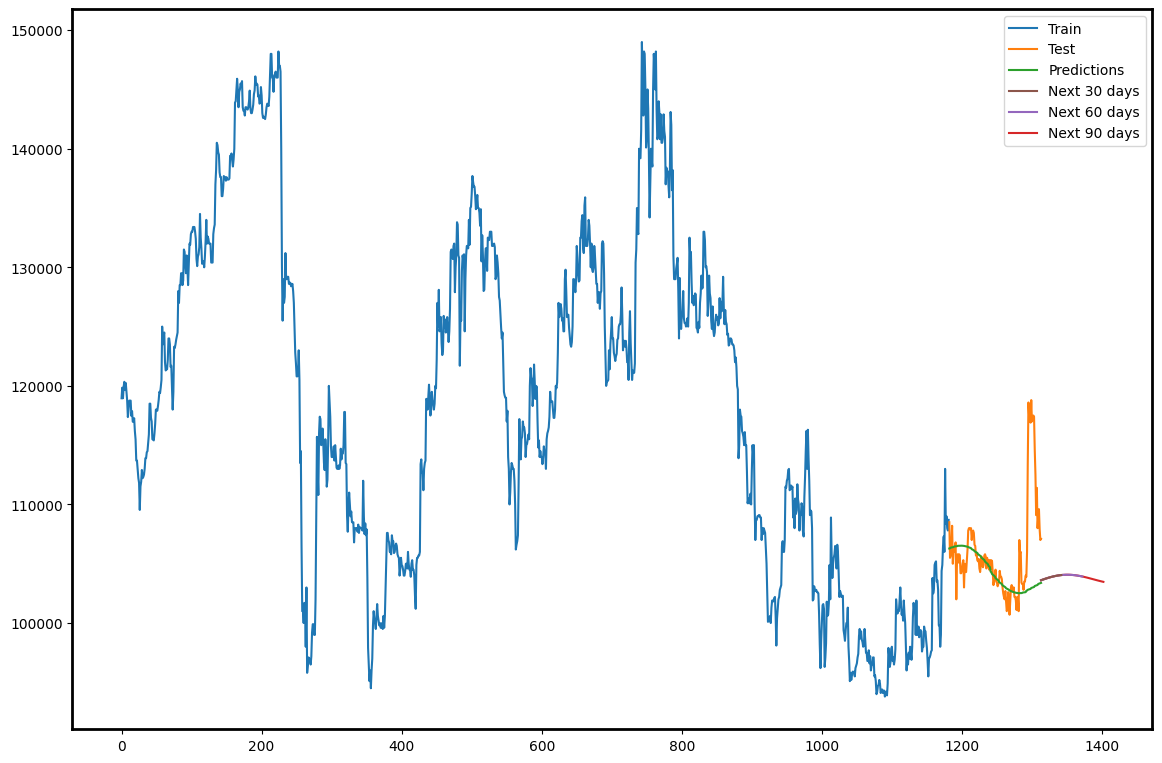

In [24]:
plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
line1, = plt.plot(train_data_index, scaler.inverse_transform(np.array(train['close']).reshape(-1,1)), label="Train")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line2, = plt.plot(test_data_index, scaler.inverse_transform(np.array(test['close']).reshape(-1,1)), label="Test")
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
line3, = plt.plot(test_data_index, test_pred['mu'], label="Predictions")
predict_90_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+89, step=1)
line4, = plt.plot(predict_90_days_index, pred_90days['mu'], label="Next 90 days")
predict_60_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+59, step=1)
line5, = plt.plot(predict_60_days_index, pred_60days['mu'], label="Next 60 days")
predict_30_days_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
line6, = plt.plot(predict_30_days_index, pred_30days['mu'], label="Next 30 days")
plt.legend(handles=[line1, line2, line3, line6, line5, line4])
plt.savefig("SEMOS_VJC_91.png")
plt.show()